# DTW-SOM Evaluation - experiment with the GunPoint dataset

## 1. Packadge import

In [35]:
import os
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from pyclustering.nnet.som import type_conn
from matrixprofile import matrixProfile, motifs
# local code
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

## 2. Preprare the GunPoint dataset

Load the dataset:

In [2]:
ucr_data_folder = os.path.abspath("../../data-ucr-archive")
file = os.path.join(ucr_data_folder, "GunPoint", "GunPoint_TRAIN.tsv")
ts_data = []
ts_labels = []
with open(file) as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t", quoting=csv.QUOTE_NONNUMERIC)
    for line in tsvreader:
        ts_labels.append(line[0])
        ts_data.append(np.array(line[1:]))
size = len(ts_data[0])
classes = len(set(ts_labels))
print("Subquence size: "+str(size))
print("No of classes: "+str(classes))
print("Dataset size:: "+str(len(ts_labels)))

Subquence size: 150
No of classes: 2
Dataset size:: 50


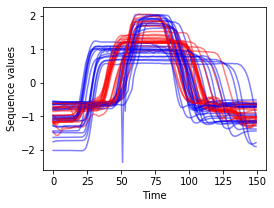

In [3]:
color_dic = {2.0: "blue", 1.0: "red"}
plt.figure(figsize=(4,3))
for i in range(len(ts_labels)):
    plt.plot(np.arange(150), ts_data[i], color=color_dic[ts_labels[i]], alpha=0.5)
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

Convert it to a single time-series by adding noise between each subsequence:

In [4]:
joined_ts_data = ts_data[0]
joined_ts_labels = [ts_labels[0]]*size
noise_size = math.ceil(size/3)
for i in range(1, len(ts_labels)):
    noise_subseq = []#np.random.normal(0,0.1, noise_size)
    joined_ts_data = np.concatenate((joined_ts_data, noise_subseq, ts_data[i]))
    joined_ts_labels = joined_ts_labels + [-2]*noise_size + [ts_labels[i]]*size
len(joined_ts_data)

7500

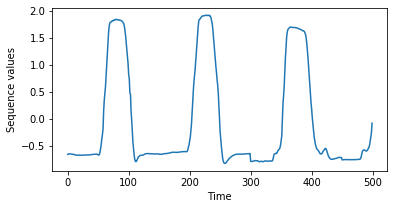

In [5]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(500), joined_ts_data[:500])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

Compute the matrix profile with STOMP:

In [6]:
%%time
mp = matrixProfile.stomp(joined_ts_data, size)

CPU times: user 4.52 s, sys: 109 ms, total: 4.62 s
Wall time: 4.76 s


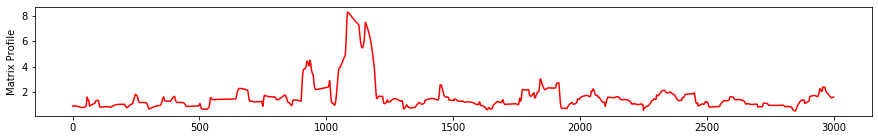

In [7]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(3000), mp_adj[:3000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extract all the motifs:

In [8]:
%%time
mtfs, motif_d  = motifs.motifs(joined_ts_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 107 ms, sys: 5.48 ms, total: 112 ms
Wall time: 121 ms


25

Create list of motifs centers:

In [9]:
motif_center_list = []
motif_center_labels = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center_ts = joined_ts_data[center_pointers]
    motif_center_list.append(motif_center_ts)
    center_labels = [joined_ts_labels[i] for i in center_pointers]
    center_final_label = max(center_labels, key=center_labels.count)
    motif_center_labels.append(center_final_label)

## 3. DTW-SOM training and results

Define the SOM network:

In [12]:
%time
rows = 3
cols = 3
structure = type_conn.grid_four
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


Train the network:

In [13]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 1.8165
Epoch 2 achieved an average quantization error of 1.7188
Epoch 3 achieved an average quantization error of 1.8259
Epoch 4 achieved an average quantization error of 1.8898
Epoch 5 achieved an average quantization error of 1.9597
Epoch 6 achieved an average quantization error of 2.044
Epoch 7 achieved an average quantization error of 2.1394
Epoch 8 achieved an average quantization error of 2.2848
Epoch 9 achieved an average quantization error of 2.242
Epoch 10 achieved an average quantization error of 2.2151
Epoch 11 achieved an average quantization error of 2.2363
Epoch 12 achieved an average quantization error of 2.2866
Epoch 13 achieved an average quantization error of 2.3068
Epoch 14 achieved an average quantization error of 2.3061
Epoch 15 achieved an average quantization error of 2.2639
Epoch 16 achieved an average quantization error of 2.2542
Epoch 17 achieved an average quantization error of 2.2514
Epoch 18 achieved an aver

50

Vizualise DTW-SOM U-matrix:

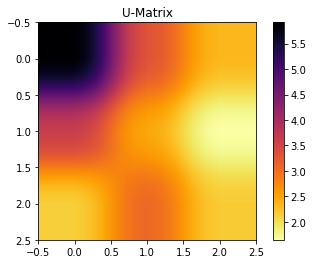

In [14]:
network.show_distance_matrix()

Vizualise the winner matrix:

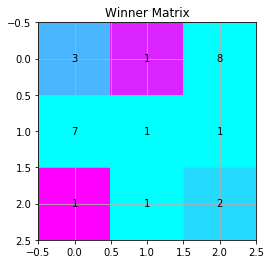

In [15]:
network.show_winner_matrix()

Vizualise the units' sequence values:

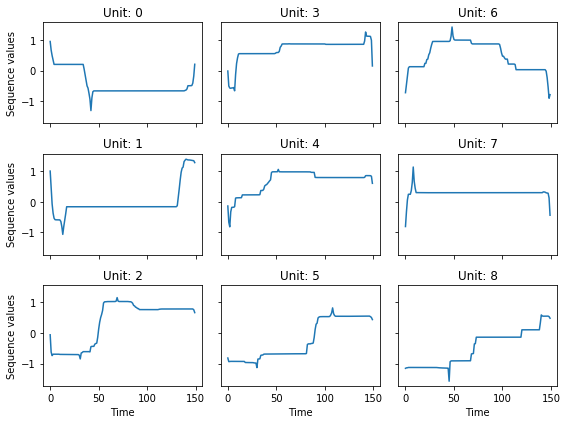

In [18]:
n_neurons = network._size
fig, axs = plt.subplots(3,3,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/3)
    row = neuron_index % 3
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [48]:
true_labels = []
predicted_labels = []
for cluster_list in network.capture_objects:
    cluster_true_labels = [motif_center_labels[i] for i in cluster_list]
    cluster_label = max(cluster_labels, key=cluster_labels.count)
    cluster_predicted_labels = [cluster_label]*len(cluster_labels)
    true_labels += cluster_true_labels
    predicted_labels += cluster_predicted_labels
accuracy = np.mean([i==j for i,j in zip(true_labels, predicted_labels)])
accuracy

0.4444444444444444